# Imports

In [1]:
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, \
    Model, \
    load_model
from tensorflow.keras.layers import Dense, \
    Activation, \
    Flatten, \
    Dropout, \
    Convolution2D, \
    MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import Precision, \
    Recall, \
    AUC, \
    TruePositives, \
    TrueNegatives, \
    FalsePositives, \
    FalseNegatives, \
    SensitivityAtSpecificity, \
    SpecificityAtSensitivity
from sklearn.metrics import classification_report, confusion_matrix
import mlflow 
import seaborn as sns
import cv2
import glob
import os
import random
from math import ceil
from time import time

/usr/lib/python3/dist-packages/ipywidgets/widgets/widget_selection.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping
/usr/lib/python3/dist-packages/ipywidgets/widgets/interaction.py:29: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Iterable, Mapping
/usr/lib/python3/dist-packages/ipywidgets/widgets/widget_link.py:19: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`) Passing types is deprecated in traitlets 4.1.
  super(WidgetTraitTuple, self).__init__(Instance(Widget), Unicode, **kwargs)


## Extract heart from image

In [2]:
first_session_init_image = glob.glob('../data/sessions/1598688579-initial.jpg')[0]
first_session_images = glob.glob('../data/sessions/1598688579/incomplete/*.jpg', recursive=True)
first_heart_image = first_session_images[0]
last_heart_image = first_session_images[len(first_session_images)-1]

print(first_session_init_image, first_heart_image)

../data/sessions/1598688579-initial.jpg ../data/sessions/1598688579/incomplete/1598688580.jpg


In [3]:
def extract_heart(init_img, actual): 
    img_1 = cv2.imread(actual)

    diff = cv2.absdiff(init_img, img_1)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    th = 40
    imask =  mask > th

    canvas = np.zeros_like(img_1, np.uint8)
    canvas[imask] = img_1[imask]
#     left 186, top 0, width 850, height 720
    canvas = canvas[0:720, 186:1036]
    
#     cv2.imshow('image', canvas)
#     cv2.waitKey(0)
#     number_of_pixels = 0
#     total_of_pixels = 0
#     for i in range(len(canvas)):
#         for j in range(len(canvas[i])):
#             avg = np.mean(canvas[i][j], )
#             if (avg > 0):
#                 number_of_pixels = number_of_pixels + 1
#                 total_of_pixels = total_of_pixels + avg
#     image_average = total_of_pixels / number_of_pixels
    canvas = np.concatenate(canvas)
#     canvas = np.concatenate(canvas)
    canvas = np.nanmean(np.where(canvas!=0,canvas,np.nan),1)
    image_average = np.nanmean(np.where(canvas!=0,canvas,np.nan),0)
#     print(image_average)
    return image_average
    
# extract_heart(first_session_init_image, first_heart_image)
# extract_heart(first_session_init_image, last_heart_image)

In [ ]:
metrics = []
init_image = cv2.imread(first_session_init_image)
for image in first_session_images:
    metrics.append(extract_heart(init_image, image))

<ipython-input-3-056de7685c6f>:28: RuntimeWarning: Mean of empty slice
  canvas = np.nanmean(np.where(canvas!=0,canvas,np.nan),1)


In [ ]:
plt.plot(metrics)
plt.ylabel('Spectrometer')
plt.show()

# Load image data

Split data set into class based dataset

In [62]:
first_session_images = glob.glob('../data/sessions/1598688579/incomplete/*.jpg', recursive=True)
second_session_images = glob.glob('../data/sessions/1599374514/incomplete/*.jpg', recursive=True)
third_session_images = glob.glob('../data/sessions/1601381361/incomplete/*.jpg', recursive=True)
fourth_session_images = glob.glob('../data/sessions/1602315776/incomplete/*.jpg', recursive=True)
fifth_session_images = glob.glob('../data/sessions/1603523854/incomplete/*.jpg', recursive=True)

    
def loadData(image_list, fold, gap):
    print("It takes ~8 hours to complete the process")
    print("This session has:")
    print(f"- {len(image_list)} images")
    print(f"- {len(image_list) /  400} cycles")
    print(f"- { 400 / 60 }")
    
    for i in range(11):
        os.makedirs(os.path.dirname(f"../dataset/{str(i).zfill(2)}/"), exist_ok=True)
        if i == 10:
            print(f"- 100% - { len(image_list) - fold + gap } to { len(image_list) }")
            for j in range(len(image_list) - fold + gap, len(image_list)):
                shutil.copy(image_list[j], f"../dataset/{str(i).zfill(2)}/{image_list[j].split(sep='/')[5]}",)
            return
        
        print(f"- {i * 10}% - { i * fold + gap } to { (i + 1) * fold }")
        for j in range(i * fold + gap, (i + 1) * fold): 
            shutil.copy(image_list[j], f"../dataset/{str(i).zfill(2)}/{image_list[j].split(sep='/')[5]}",)
        
    
loadData(first_session_images, 3200, 400)
loadData(second_session_images, 3200, 400)
loadData(third_session_images, 3200, 400)
loadData(fourth_session_images, 3200, 400)
loadData(fifth_session_images, 3200, 400)

It takes ~8 hours to complete the process
This session has:
- 47562 images
- 118.905 cycles
- 6.666666666666667
- 0% - 400 to 3200
- 10% - 3600 to 6400
- 20% - 6800 to 9600
- 30% - 10000 to 12800
- 40% - 13200 to 16000
- 50% - 16400 to 19200
- 60% - 19600 to 22400
- 70% - 22800 to 25600
- 80% - 26000 to 28800
- 90% - 29200 to 32000
- 100% - 44762 to 47562
It takes ~8 hours to complete the process
This session has:
- 41239 images
- 103.0975 cycles
- 6.666666666666667
- 0% - 400 to 3200
- 10% - 3600 to 6400
- 20% - 6800 to 9600
- 30% - 10000 to 12800
- 40% - 13200 to 16000
- 50% - 16400 to 19200
- 60% - 19600 to 22400
- 70% - 22800 to 25600
- 80% - 26000 to 28800
- 90% - 29200 to 32000
- 100% - 38439 to 41239
It takes ~8 hours to complete the process
This session has:
- 32060 images
- 80.15 cycles
- 6.666666666666667
- 0% - 400 to 3200
- 10% - 3600 to 6400
- 20% - 6800 to 9600
- 30% - 10000 to 12800
- 40% - 13200 to 16000
- 50% - 16400 to 19200
- 60% - 19600 to 22400
- 70% - 22800 to 256

# Image augumentation functions

In [2]:
def loadImage(path):
    img = cv2.imread(path)
    return img

def cropImage(img, left, top, width, height):
#     left: 170, top: 40, width: 650, height: 650 
    img = img[top:top+height, left:left+width]
    return img

def blurImage(img, blur):
    img = cv2.blur(img, (blur, blur))
    return img

def resizeImage(img, size):
    img = cv2.resize(img, (size, size), cv2.INTER_CUBIC)
    return img

def rotateImage(image, degree):
    (rows, cols, ch) = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degree, 1)
    return cv2.warpAffine(image, M, (cols,rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

def saveImage(img, newPath):
    cv2.imwrite(newPath, img)

def preprocess_images(image_paths):
    initial_folder = 'dataset'
    new_folder = 'dataset-preprocessed'
    os.makedirs(os.path.dirname(f"../dataset-preprocessed/"), exist_ok=True)
    for i in range(11): 
        os.makedirs(os.path.dirname(f"../dataset-preprocessed/{str(i).zfill(2)}/"), exist_ok=True)
    
    for path in image_paths:
        initial_image = loadImage(path)
        shifts = [ 0 ]
        shifts.append(np.random.randint(0, 100))
        shifts.append(np.random.randint(0, 100))
        shifts.append(np.random.randint(-100, 0))
        shifts.append(np.random.randint(-100, 0))
    

        for i in shifts:
            image = cropImage(initial_image, 186 + i, 0, 850, 720) 
            image = resizeImage(image, 200)
            saveImage(image, path.replace(initial_folder, new_folder).replace('.jpg', f"-resized-{i}.jpg"))
            image = blurImage(image, 5)
            saveImage(image, path.replace(initial_folder, new_folder).replace('.jpg', f"-blured-{i}.jpg"))
            image = rotateImage(image, np.random.randint(0, 360))
            saveImage(image, path.replace(initial_folder, new_folder).replace('.jpg', f"-rotated-{i}.jpg"))


def simple_preprocess_images(image_paths):
    initial_folder = 'dataset'
    new_folder = 'dataset-preprocessed'
    os.makedirs(os.path.dirname(f"../dataset-preprocessed/"), exist_ok=True)
    for i in range(11): 
        os.makedirs(os.path.dirname(f"../dataset-preprocessed/{str(i).zfill(2)}/"), exist_ok=True)
    for path in image_paths:
        initial_image = loadImage(path)
        
        image = cropImage(initial_image, 186 + i, 0, 850, 720) 
        image = resizeImage(image, 200)
        saveImage(image, path.replace(initial_folder, new_folder))

def moveAndCrop(session):
    image_paths = glob.glob(f"../data/sessions/{session}/**/*.jpg", recursive=True)
    incomplete_folder = f"data/sessions/{session}/incomplete"
    complete_folder = f"data/sessions/{session}/complete"
    new_folder = 'dataset-test'
    destination_folder = f"{new_folder}/{session}"
    os.makedirs(os.path.dirname(f"../{new_folder}/"), exist_ok=True)
    os.makedirs(os.path.dirname(f"../{destination_folder}/"), exist_ok=True)
    for path in image_paths:
        initial_image = loadImage(path)
        image = cropImage(initial_image, 186, 0, 850, 720) 
        image = resizeImage(image, 200)
        saveImage(image, path.replace(incomplete_folder, destination_folder).replace(complete_folder, destination_folder))

    

In [3]:
all_image_paths = glob.glob('../dataset/**/*.jpg', recursive=True)
simple_preprocess_images(all_image_paths)


In [57]:
# moveAndCrop('1598688579')
# moveAndCrop('1599374514')
# moveAndCrop('1601381361')
# moveAndCrop('1602315776')
# moveAndCrop('1603523854')

### Plot dataset distribution, as we can see the classes are well ballanced

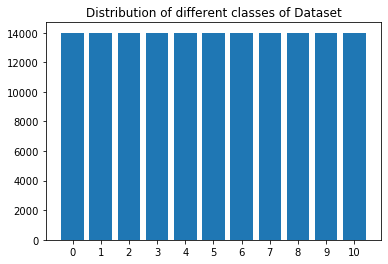

154000 items


In [4]:

def plotDistributionOfClasses(partial_path):
    nimgs = {}
    total = 0
    
    for i in range(11):
        nimages = len(os.listdir(f"../{partial_path}/{str(i).zfill(2)}/"))
        nimgs[i]=nimages
        total = total + nimages
        
    plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
    plt.xticks(range(len(nimgs)), list(nimgs.keys()))
    plt.title('Distribution of different classes of Dataset')
    plt.show()
    print(f"{total} items") 

plotDistributionOfClasses('dataset-preprocessed')


## Make train, validation and test split

In [5]:
from_folder = 'dataset-preprocessed'
to_folder = 'dataset-split'

all_image_paths = glob.glob(f"../{from_folder}/**/*.jpg", recursive=True)
print(len(all_image_paths))
total_images = len(all_image_paths)
train_images_limit = ceil(total_images / 10 * 8)
validation_images_limit = ceil(total_images / 10 * 9)
test_images_limit = total_images

numbered_list = list(range(len(all_image_paths)))
random.shuffle(numbered_list)
old_image_list = [all_image_paths[index] for index in numbered_list]
new_image_list = [all_image_paths[index] for index in numbered_list]

train_split = new_image_list[0:train_images_limit - 1]
print(len(train_split))
validation_split = new_image_list[train_images_limit:validation_images_limit - 1]
print(len(validation_split))
test_split = new_image_list[validation_images_limit:test_images_limit - 1]
print(len(test_split))

for i in range(11):
    os.makedirs(os.path.dirname(f"../{to_folder}/train/{str(i).zfill(2)}/"), exist_ok=True)
    os.makedirs(os.path.dirname(f"../{to_folder}/validation/{str(i).zfill(2)}/"), exist_ok=True)
    os.makedirs(os.path.dirname(f"../{to_folder}/test/{str(i).zfill(2)}/"), exist_ok=True)

for i in range(len(train_split)):
    new_path = train_split[i].replace(from_folder, f"{to_folder}/train")
    shutil.copy(train_split[i], new_path)

for i in range(len(validation_split)):
    new_path = validation_split[i].replace(from_folder, f"{to_folder}/validation")
    shutil.copy(validation_split[i], new_path)
    
for i in range(len(test_split)):
    new_path = test_split[i].replace(from_folder, f"{to_folder}/test")
    shutil.copy(test_split[i], new_path)
 

154000
123199
15399
15399


## Plot class distributions of dataset split

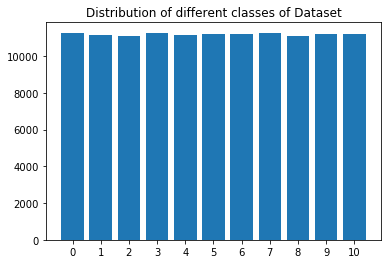

123199 items


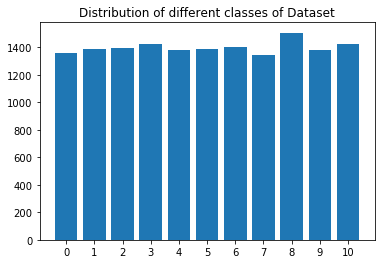

15399 items


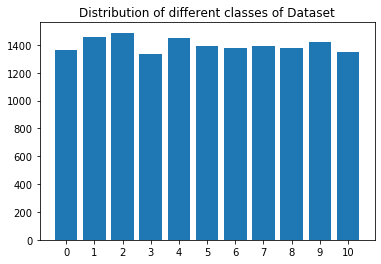

15399 items


In [6]:
plotDistributionOfClasses('dataset-split/train')
plotDistributionOfClasses('dataset-split/validation')
plotDistributionOfClasses('dataset-split/test')

### Hyperparameters

In [ ]:
train_len = 733219
validation_len = 91651
test_len = 91651
size = 200
batch_size = 32
epochs = 50
start_run_time = time()

steps_per_epoch = ceil(train_len / batch_size)
validation_steps = ceil(validation_len / batch_size)
test_steps = ceil(test_len / batch_size)

RUN_NAME = f"cnn-s{size}-bs{batch_size}-e{epochs}-spe{steps_per_epoch}-{start_run_time}"

### Create model

In [ ]:
def createModel():
    model = Sequential()
    model.add(Convolution2D(24, (3, 3), activation='relu', input_shape=(size, size, 3)))                       
    model.add(MaxPooling2D((2, 2)))
    model.add(Convolution2D(48, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Convolution2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Convolution2D(96, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(384, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    
    model.summary()

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', 
                                                                              AUC(), 
                                                                              Precision(), 
                                                                              Recall(),
                                                                              TruePositives(),
                                                                              TrueNegatives(),
                                                                              FalsePositives(),
                                                                              FalseNegatives(),
#                                                                               SensitivityAtSpecificity(),
#                                                                               SpecificityAtSensitivity()
                                                                             ])
    
    return model

### Image data generator

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_generator= train_datagen.flow_from_directory(f"../dataset-split/train",
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   class_mode='categorical',
                                                   target_size=(size, size))


validation_datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(f"../dataset-split/validation",
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(size, size))

# test_generator = ImageDataGenerator(f"../dataset-split/test", class_mode="categorical")


In [ ]:
target_dir = './models/'
if not os.path.exists(target_dir):
    os.mkdir(target_dir)
if not os.path.exists(f"{target_dir}{RUN_NAME}"):
    os.mkdir(f"{target_dir}{RUN_NAME}")

target_dir = f"{target_dir}{RUN_NAME}"

best_model_file = f"{target_dir}/best-weights.h5"

callbacks = [
#     EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto'),
    ModelCheckpoint(best_model_file, monitor='val_accuracy', verbose = 1, save_best_only = True),
    TensorBoard(f"logs/{RUN_NAME}")
]


In [ ]:
model = createModel()
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=callbacks)

# Save the model 

In [ ]:
loss = model.evaluate_generator(validation_generator, steps=validation_steps, verbose=1)

In [ ]:
model.save(f"{target_dir}/model.h5")
model.save_weights(f"{target_dir}/weights.h5")



In [ ]:
# model = load_model(f"{target_dir}/model.h5")
# model.load_weights(f"{target_dir}/weights.h5")
# model.load_weights(f"{target_dir}/best-weights.h5")
target_dir = 'models/cnn-s200-bs32-e120-spe1700--dr0.2-fn32-lr0.001'
model = load_model(f"{target_dir}/model.h5")
model.load_weights(f"{target_dir}/best-weights.h5")
# model.load_weights(f"{target_dir}/weights.h5")

In [ ]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(f"../dataset-split/test",
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    target_size=(size, size))


In [58]:
predictions = model.predict_generator(test_generator, steps=test_steps, verbose=1)
predictions = np.argmax(predictions, axis=1)


Confusion Matrix


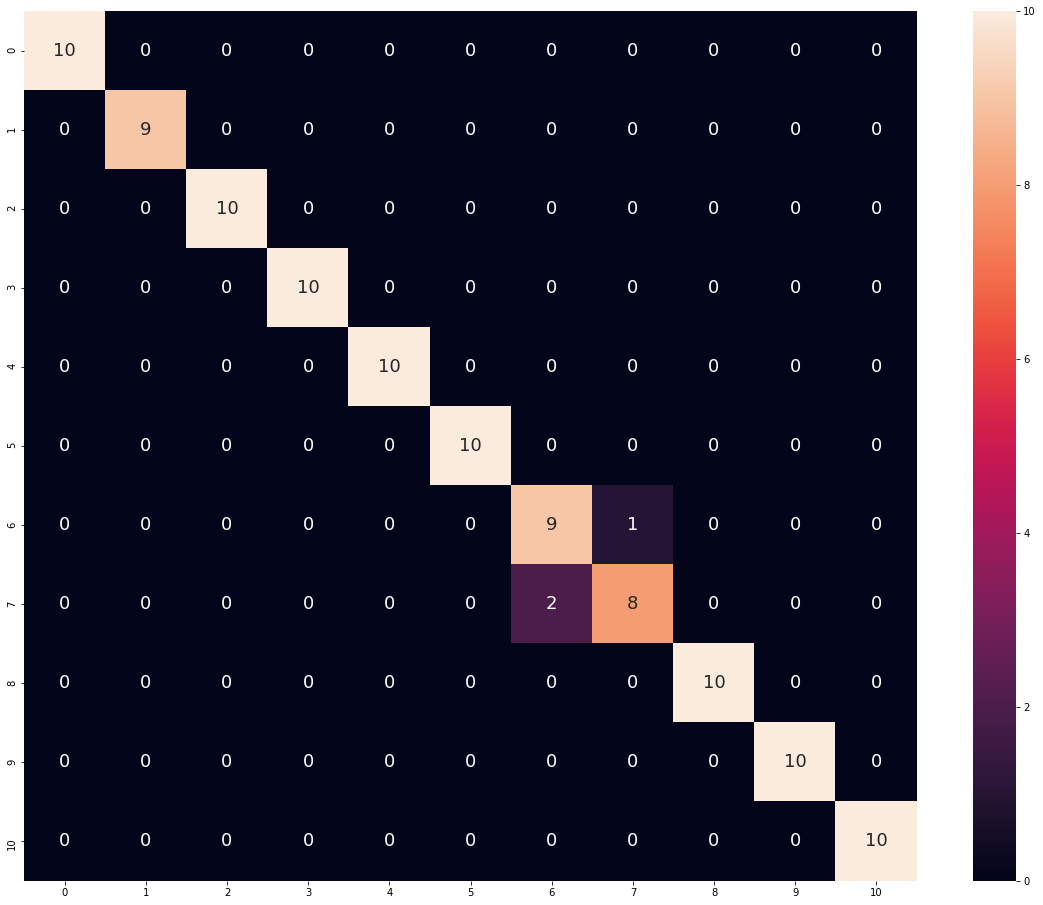

In [59]:
# predictions = np.argmax(predictions, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, predictions)
fig, ax = plt.subplots(figsize=(20,16)) 
sns.heatmap(cm, annot=True, ax=ax, fmt='g', annot_kws={"fontsize":18})

In [ ]:
fig.savefig('confusion-matrix.png')

In [53]:
print('Classification Report')
target_names = ['0', '1', '2','3','4','5','6','7','8','9','10']
class_report = classification_report(test_generator.classes, predictions, target_names=target_names)
print(class_report)


Classification Report


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [ ]:
with open("classification-report.txt", 'w') as f:
    f.write(class_report)

### Prediction test

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
model = load_model("models/cnn-all-loss-s200-bs32-e120-spe3850-dr0.15-fn32-lr0.001-rtl2-rr0.15/model.h5")
model.load_weights("models/cnn-all-loss-s200-bs32-e120-spe3850-dr0.15-fn32-lr0.001-rtl2-rr0.15/best-weights.h5")

#### Test on normal predictions

In [14]:

# test_datagen = ImageDataGenerator(rescale=1. / 255)
# test_generator = test_datagen.flow_from_directory(f"./test",
#                                                     batch_size=1,
#                                                     shuffle=False,
#                                                     class_mode='categorical',
#                                                     target_size=(200, 200))

img = image.load_img('./test/10/1599416780.jpg', target_size=(200, 200))
img_array = image.img_to_array(img) * 0.00392156862745098
# print(img_array)
img_batch = np.expand_dims(img_array , axis=0)
prediction = model.predict(img_batch)
# batchX, batchy = test_generator.next()
# print(batchX)
# predictions = model.predict_generator(test_generator)
classes = np.argmax(prediction, axis=1)
print(classes)

[10]


In [3]:
def makePredictionOnEntireSession(session):
    image_paths = glob.glob(f"../dataset-test/{session}/**/*.jpg", recursive=True)
    predictions = []
    i = 0
    for path in image_paths: 
        img = image.load_img(path, target_size=(200, 200))
        img_array = image.img_to_array(img) * 0.00392156862745098
        img_batch = np.expand_dims(img_array , axis=0)
        prediction = model.predict(img_batch)
        classes = np.argmax(prediction, axis=1)
        time = path.split('/')[3].split('.')[0]
        predicted_class = classes[0]
        predictions.append([i, int(time), int(predicted_class)])
        i = i + 1
    
    npred = np.asarray(predictions) 
    
    plt.scatter(npred[:, 0], npred[:, 2], s=35, vmin=0, vmax=10, label="Classification")
    plt.xlabel("Time")
    plt.ylabel("Class")
    plt.legend(loc='upper left')
    plt.show()

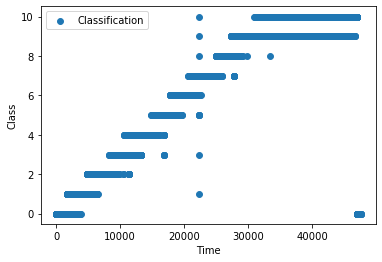

In [6]:
makePredictionOnEntireSession('1598688579')

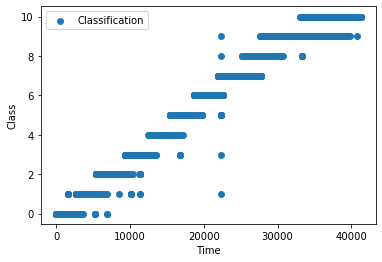

In [7]:
makePredictionOnEntireSession('1599374514')

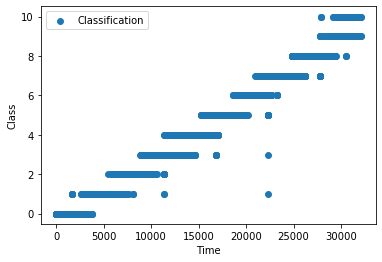

In [8]:
makePredictionOnEntireSession('1601381361')

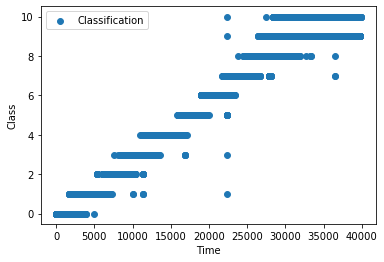

In [9]:
makePredictionOnEntireSession('1602315776')

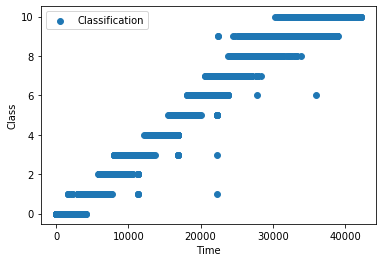

In [10]:
makePredictionOnEntireSession('1603523854')

In [ ]:
# npred = np.asarray(predictions) 
# print(npred.shape)

In [ ]:
# plt.scatter(npred[:, 0], npred[:, 2], s=35, vmin=0, vmax=10, label="Classification")
# plt.xlabel("Time")
# plt.ylabel("Class")
# plt.legend(loc='upper left')
# plt.show()

### Convert python model into js model

In [15]:
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model

model = load_model("models/cnn-no-suf-loss-s200-bs32-e120-spe1540-dr0.15-fn32-lr0.001-rtl2-rr0.15/model.h5")
model.load_weights("models/cnn-no-suf-loss-s200-bs32-e120-spe1540-dr0.15-fn32-lr0.001-rtl2-rr0.15/best-weights.h5")
tfjs.converters.save_keras_model(model, 'tfjs_models')


/home/taddeus/.local/lib/python3.8/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [ ]:
!pip install tensorflowjs tensorflow-gpu==2.3.1